# Sequence-to-Sequence: Language Translation

In this assignment you will use a database of pairs of (English,French) sentences to train an RNN model to translate from English to French.

The directory ../resource/asnlib/publicdata contains two files, "small_vocab_en.txt" and "small_vocab_fr.txt". Line "n" of the first file corresponds to line "n" of the second file.

Also see data here: http://www.statmt.org/wmt14/translation-task.html

Keras resources: 
* https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html
* https://machinelearningmastery.com/return-sequences-and-return-states-for-lstms-in-keras/
* https://stackoverflow.com/questions/38714959/understanding-keras-lstms/50235563#50235563

Neural Language Translation Resources:
* https://arxiv.org/abs/1703.01619
* https://www.tensorflow.org/tutorials/seq2seq

# Setup
## Imports

In [1]:
import math
import os
import string

import matplotlib.pyplot as plt

from IPython.display import SVG

from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Input, GRU, LSTM, Dense, Masking, Dropout, Embedding, Flatten, Dense
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences
from keras.regularizers import l1_l2
from keras.utils import to_categorical
from keras.utils.vis_utils import model_to_dot
from sklearn.model_selection import train_test_split
from keras.backend.tensorflow_backend import set_session

import numpy as np
import tensorflow as tf

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary

## Configure Tensorflow to be less aggressive about RAM utilization when it starts up.

In [2]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.1  # Start with 10% of the GPU RAM
config.gpu_options.allow_growth = True                    # Dynamically grow the memory used on the GPU
sess = tf.Session(config=config)
set_session(sess)                                         # Set this TensorFlow session as the default session for Keras

In [3]:
TRAIN_TEST_SPLIT = 0.7           # % of data in training set

NUM_LSTM_NODES = 256             # Num of intermediate LSTM nodes
CONTEXT_VECTOR_SIZE = 256        # Size of context vector (num of LSTM nodes in final LSTM layer)

EMBEDDING_DIM = 100              # Embedding layer size for input words

BATCH_SIZE = 64
NUM_EPOCHS = 1000

NUM_DATA_EXAMPLES = 5000         # limit memory usage

LR = 0.01
DROPOUT = 0.3

In [4]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [5]:
def add_space_around_punctuation(s):
    result = ''
    for c in s:
        if c in string.punctuation and c != "'":
            result += ' %s ' % c
        else:
            result += c
    return result

In [6]:
#PUNCTUATION_REMOVER = str.maketrans('','',string.punctuation)
    
def clean_sentence(s):
    s = s.strip()
    s = s.lower()
    #s = s.translate(PUNCTUATION_REMOVER)
    s = add_space_around_punctuation(s)
    return s

def get_words_from_sentence(s, add_start_symbol=False, add_end_symbol=True, reverse=False):
#def get_words_from_sentence(s, add_start_symbol=False, add_end_symbol=False, reverse=False):
    words = list(filter(None, s.split(' ')))
    if reverse:
        words = words[::-1]
    if add_start_symbol:
        words = ['<S>'] + words
    if add_end_symbol:
        words.append('</S>')
    return words

def get_word_list_from_sentence_string(s, add_start_symbol=False, add_end_symbol=True, reverse=False):
    return get_words_from_sentence(clean_sentence(s), add_start_symbol, add_end_symbol, reverse)    
    
def get_sentences(path, filename, add_start_symbol=False, add_end_symbol=True, reverse=False):
#def get_sentences(path, filename, add_start_symbol=False, add_end_symbol=False, reverse=False):
    with open(os.path.join(path, filename), 'r') as f:
        lines = f.readlines()
        return [get_word_list_from_sentence_string(s, add_start_symbol, add_end_symbol, reverse) 
                for s in lines]

def get_word_set(sentences):
    words = set()
    for s in sentences:
        for word in s:
            words.add(word)
    return words
            

In [7]:
PATH = '../resource/asnlib/publicdata'
s1 = get_sentences(PATH, 'small_vocab_en.txt', reverse=True, add_end_symbol=False) # Reverse input sentences for training
s2 = get_sentences(PATH, 'small_vocab_fr.txt', add_start_symbol=True)
#s1 = get_sentences(PATH, 'small_vocab_en.txt', reverse=False, add_end_symbol=False) # Reverse input sentences for training
#s2 = get_sentences(PATH, 'small_vocab_fr.txt', add_start_symbol=True)

In [8]:
# Only get a subset of the data
s1 = s1[:NUM_DATA_EXAMPLES]
s2 = s2[:NUM_DATA_EXAMPLES]

In [9]:
w1 = list(get_word_set(s1))
w2 = list(get_word_set(s2))

In [10]:
for w in w1[:10]:
    print(w)
print()
for w in w2[:10]:
    print(w)

dislike
nice
elephants
didn't
did
they
wonderful
translate
weather
easy

ne
enneigée
aimée
dernière
inde
préféré
l'oiseau
occupé
allez
-


In [11]:
def get_word_to_index_dict(words):
    return {w: i+1 for i,w in enumerate(words)}  # use i+1 to reserve 0 for the mask index
def reverse_dict(d):
    return {v: k for k,v in d.items()}

In [12]:
word_to_index1 = get_word_to_index_dict(w1)
word_to_index2 = get_word_to_index_dict(w2)
index_to_word1 = reverse_dict(word_to_index1)
index_to_word2 = reverse_dict(word_to_index2)
index_to_word1[0] = '<MASK>'
index_to_word2[0] = '<MASK>'

In [13]:
def sentence_to_indices(s, word_to_index):
    return [word_to_index[w] for w in s]

In [14]:
def indices_to_sentence(indices, index_to_word):
    return [index_to_word[i] for i in indices]

In [15]:
x = sentence_to_indices(get_word_list_from_sentence_string('vous aimez raisins.', add_start_symbol=True), word_to_index2)
x

[171, 33, 46, 20, 304, 122]

In [16]:
indices_to_sentence(x, index_to_word2)

['<S>', 'vous', 'aimez', 'raisins', '.', '</S>']

In [17]:
num_words_X = len(w1) + 1  # add 1 to reserve 0 for mask
num_words_y = len(w2) + 1  # add 1 to reserve 0 for mask
num_words_X, num_words_y

(197, 310)

In [18]:
inputs_as_indices = [sentence_to_indices(s, word_to_index1) for s in s1]
outputs_as_indices = [sentence_to_indices(s, word_to_index2) for s in s2]

In [19]:
inputs = pad_sequences(inputs_as_indices)
outputs = pad_sequences(outputs_as_indices, padding='post')

In [20]:
max_seq_len_X = len(inputs[0])
max_seq_len_y = len(outputs[0])
max_seq_len_X, max_seq_len_y

(17, 24)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, 
                                                    test_size=1 - TRAIN_TEST_SPLIT,
                                                    random_state=42)

In [22]:
# We need to one-hot-encode the outputs ourselves for use in the loss function. 
# The inputs get this for free via use of Embedding layers in Keras.
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [23]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3499, 17), (1501, 17), (3499, 24), (1501, 24))

# Create Model

Now we need to write code to build the SeqToSeq model. **Important**: In Keras we have to use the "functional API" in order to access the LSTM internal state that we use as the "context vector" or "encoding" of a sentence. We also need to store hooks into the model to be able to run the translator on new sentences after training.

This code will create variables representing the entire SeqToSeq model (for use in training), as well as the individual encoder segment and decoder segment of the model, for use in inference.

## Encoder

We will implement the following architecture:
    
1. Encoder input: shape (max_seq_len_X,)
2. Masking layer: doesn't change shape. Ignores leading "-1"s in shorter sequences.
3. Embedding layer: output shape (max_seq_len_X, EMBEDDING_DIM)
4. LSTM layer 1. N.B. The first LSTM layer in a stack must use "return_sequences=True"
5. LSTM layer 2. N.B. The final layer must use "return_state=True" so we can extract the internal state (the context vector).

In [24]:
# Build RNN model.
# See also: https://machinelearningmastery.com/define-encoder-decoder-sequence-sequence-model-neural-machine-translation-keras/

encoding_size = CONTEXT_VECTOR_SIZE
max_input_seq_len = max_seq_len_X
max_output_seq_len = max_seq_len_y
num_input_words = num_words_X
num_output_words = num_words_y

encoder_inputs = Input(shape=(max_input_seq_len,), name='encoder_input')
encoder_inputs_masked = Masking(mask_value=0, name='encoder_masking')(encoder_inputs)
encoder_inputs_embedded = Embedding(num_input_words, EMBEDDING_DIM, mask_zero=True, name='encoder_embedding')(encoder_inputs_masked)
encoder_outputs1, state_h1, state_c1 = LSTM(NUM_LSTM_NODES, return_sequences=False, return_state=True,
                                            name='encoder_lstm_1')(encoder_inputs_embedded)

# Discard `encoder_outputs2` and only keep the states.
encoder_states1 = [state_h1, state_c1]

## Decoder

### The decoder should have the following architecture:
    
1. Decoder input: shape (max_seq_len_y,)
2. Masking layer: doesn't change shape. Ignores final "-1"s in shorter sequences.
3. Embedding layer: output shape (max_seq_len_y, EMBEDDING_DIM)
4. LSTM layer 1. N.B. The first LSTM layer in a stack must use "return_sequences=True"
5. LSTM layer 2. N.B. The final layer must use "return_state=True" so we can extract the internal state.
6. Dense layer with softmax: output shape (num_output_words,)

In [25]:
# Decoder section
# Set up the decoder, using encoder_states as initial state.
decoder_inputs = Input(shape=(None,), name='decoder_input')
decoder_inputs_masked = Masking(mask_value=0, name='decoder_masking')(decoder_inputs)
decoder_inputs_embedded = Embedding(num_output_words, EMBEDDING_DIM, mask_zero=True, 
                                    name='decoder_embedding')(decoder_inputs_masked)
decoder_lstm_1 = LSTM(NUM_LSTM_NODES, return_sequences=True, return_state=True, name='decoder_lstm_1')
z, _, _ = decoder_lstm_1(decoder_inputs_embedded, initial_state=encoder_states1)
decoder_dense = Dense(num_output_words, activation='softmax', name='decoder_output')
decoder_outputs = decoder_dense(z)
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`

### Put it all together into one model, and visualize

In [26]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 17)           0                                            
__________________________________________________________________________________________________
decoder_input (InputLayer)      (None, None)         0                                            
__________________________________________________________________________________________________
encoder_masking (Masking)       (None, 17)           0           encoder_input[0][0]              
__________________________________________________________________________________________________
decoder_masking (Masking)       (None, None)         0           decoder_input[0][0]              
__________________________________________________________________________________________________
encoder_em

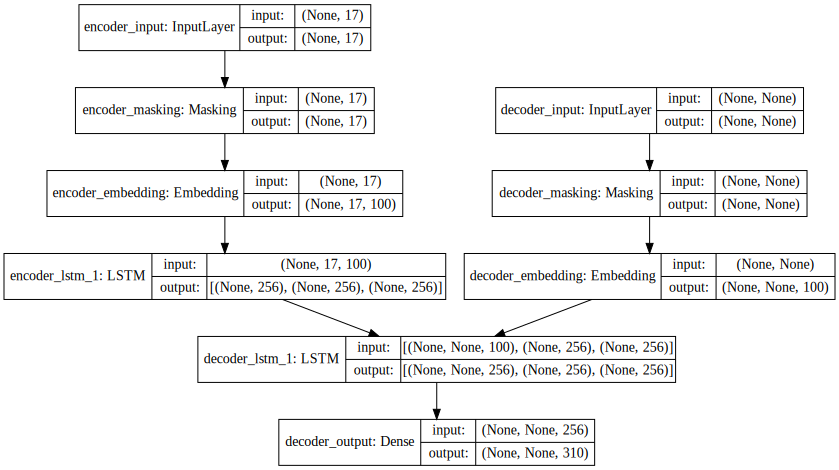

In [27]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [28]:
encoder_input_data = X_train

In [29]:
decoder_input_data = y_train

In [30]:
# decoder_target_data will be ahead by one timestep
# and will not include the start token.
decoder_target_data = np.zeros(y_train_one_hot.shape)
decoder_target_data[:,:-1] = y_train_one_hot[:,1:,:]


In [31]:
decoder_target_data_test = np.zeros(y_test_one_hot.shape)
decoder_target_data_test[:,:-1] = y_test_one_hot[:,1:,:]

In [32]:
print(encoder_input_data[0], decoder_input_data[0], decoder_target_data[0])
print(decoder_input_data[0][:2], decoder_target_data[0][:1])

print(encoder_input_data.shape, decoder_input_data.shape, 
      decoder_target_data.shape)

[  0   0 193 127  59  60 134  27 103  78  12  45 192 134  89  66 110] [171 301 260  10 134 142  93  38 207 132 189  99 305  38 224 304 122   0
   0   0   0   0   0   0] [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[171 301] [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [33]:
optimizer = Adam(lr=.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy')
#model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy')

In [34]:
lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1, mode='auto', 
                                cooldown=0, min_lr=0)

In [35]:
early_stopping_callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')

In [36]:
# Run training
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=BATCH_SIZE,
          epochs=NUM_EPOCHS,
          validation_data=([X_test, y_test], decoder_target_data_test),
          callbacks=[lr_callback, early_stopping_callback])

Train on 3499 samples, validate on 1501 samples
Epoch 1/1000
3499/3499 [==============================] - 29s 8ms/step - loss: 4.1515 - val_loss: 3.3765
Epoch 2/1000
3499/3499 [==============================] - 27s 8ms/step - loss: 2.9331 - val_loss: 2.4794
Epoch 3/1000
3499/3499 [==============================] - 25s 7ms/step - loss: 2.1316 - val_loss: 1.7942
Epoch 4/1000
3499/3499 [==============================] - 26s 8ms/step - loss: 1.5697 - val_loss: 1.3812
Epoch 5/1000
3499/3499 [==============================] - 26s 7ms/step - loss: 1.2643 - val_loss: 1.1737
Epoch 6/1000
3499/3499 [==============================] - 26s 8ms/step - loss: 1.0943 - val_loss: 1.0367
Epoch 7/1000
3499/3499 [==============================] - 25s 7ms/step - loss: 0.9791 - val_loss: 0.9479
Epoch 8/1000
3499/3499 [==============================] - 25s 7ms/step - loss: 0.8999 - val_loss: 0.8830
Epoch 9/1000
3499/3499 [==============================] - 27s 8ms/step - loss: 0.8430 - val_loss: 0.8334
Epoch 1

In [37]:
# Save model
model.save('s2s.h5')

/usr/local/lib/python3.5/dist-packages/keras/engine/topology.py:2368: UserWarning: Layer decoder_lstm_1 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'encoder_lstm_1/while/Exit_2:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'encoder_lstm_1/while/Exit_3:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


# Inference

We have trained a model, but how do we use it to actually translate sentences? We have to do more work ourselves here than with a non-recurrent neural net, so we'll write a function to help out. Here are the steps:

1. **Encode**:
    1. Run the entire input sentence through the encoder part of the model.
    1. Write down the "context vector" -- this is the state of the last LSTM encoder layer.<br><br>

2. **Decode in a loop**:
    1. Seed the decoder LSTM with the context vector.
    1. Run a *single step* of the decoder with the input "`<S>`" (the start symbol).
    1. Store the output. This is a word of the translation!
    1. Return to step 2B, but feed in the word from step 2C as the new input. Repeat until the decoder returns "`</S>`" (the end symbol).

In [38]:
# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states1)
encoder_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 17)                0         
_________________________________________________________________
encoder_masking (Masking)    (None, 17)                0         
_________________________________________________________________
encoder_embedding (Embedding (None, 17, 100)           19700     
_________________________________________________________________
encoder_lstm_1 (LSTM)        [(None, 256), (None, 256) 365568    
Total params: 385,268
Trainable params: 385,268
Non-trainable params: 0
_________________________________________________________________


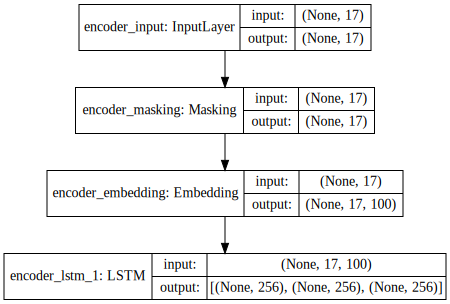

In [39]:
SVG(model_to_dot(encoder_model, show_shapes=True).create(prog='dot', format='svg'))

In [40]:
decoder_state_input_h = Input(shape=(NUM_LSTM_NODES,))
decoder_state_input_c = Input(shape=(NUM_LSTM_NODES,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs1, state_h1, state_c1 = decoder_lstm_1(
    decoder_inputs_embedded, initial_state=decoder_states_inputs)

decoder_states1 = [state_h1, state_c1]
decoder_outputs = decoder_dense(decoder_outputs1)
decoder_model = Model([decoder_inputs] + decoder_states_inputs,
                      [decoder_outputs] + decoder_states1)
decoder_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_input (InputLayer)      (None, None)         0                                            
__________________________________________________________________________________________________
decoder_masking (Masking)       (None, None)         0           decoder_input[0][0]              
__________________________________________________________________________________________________
decoder_embedding (Embedding)   (None, None, 100)    31000       decoder_masking[0][0]            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 256)          0                                            
__________________________________________________________________________________________________
input_2 (I

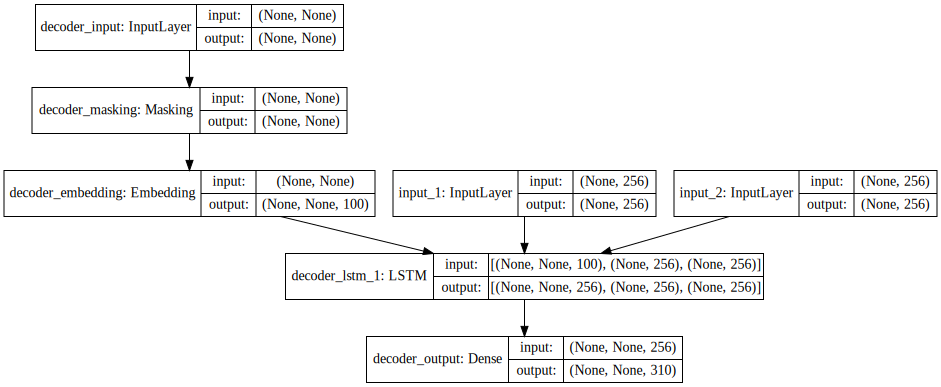

In [41]:
SVG(model_to_dot(decoder_model, show_shapes=True).create(prog='dot', format='svg'))

In [42]:
def translate_sequence(input_seq):
    # Encode the input as state vectors.
    h1, c1 = encoder_model.predict(input_seq)
    states_value1 = [h1, c1]
    # Generate empty target sequence of length 1 (one-hot encoded).
    #target_seq = np.zeros((1, num_output_words))
    target_seq = np.zeros((1,1))
    # Populate the first word of target sequence with the start symbol.
    #target_seq[0, word_to_index2['<S>']] = 1.
    target_seq[0,0] = word_to_index2['<S>']
    
    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    step = 0
    while not stop_condition:
        #print('step:', step)
        #print(states_value1[0][0][0:5])
    
        output_tokens, h1, c1  = decoder_model.predict(
            [target_seq] + states_value1)

        # Sample a token
        #print(output_tokens)
        #sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token_index = np.argmax(output_tokens[0, 0, :])
        sampled_word = index_to_word2[sampled_token_index]
        #print(sampled_word)
        decoded_sentence += sampled_word + ' '
        step += 1
        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_word == '</S>' or step > max_output_seq_len):
            stop_condition = True

        # Update the target sequence (of length 1).
        #target_seq = np.zeros((1, num_output_words))
        #target_seq[0, sampled_token_index] = 1.
        target_seq[0, 0] = sampled_token_index
        # Update states
        states_value1 = [h1, c1]

    return decoded_sentence

In [43]:
for i in range(10):
    print(indices_to_sentence(X_test[i], index_to_word1)[::-1])
    print(translate_sequence(np.expand_dims(X_test[i], axis=0)))

['my', 'most', 'loved', 'fruit', 'is', 'the', 'banana', ',', 'but', 'their', 'most', 'loved', 'is', 'the', 'orange', '.', '<MASK>']
mon fruit le plus aimé est la banane , mais leur plus aimé est l'orange . </S> 
['she', 'likes', 'apples', ',', 'oranges', ',', 'and', 'strawberries', '.', '<MASK>', '<MASK>', '<MASK>', '<MASK>', '<MASK>', '<MASK>', '<MASK>', '<MASK>']
elle aime les pommes , les oranges et les fraises . </S> 
['the', 'banana', 'is', 'our', 'least', 'favorite', 'fruit', ',', 'but', 'the', 'grape', 'is', 'their', 'least', 'favorite', '.', '<MASK>']
la banane est notre fruit préféré moins , mais le raisin est leur moins préféré . </S> 
['paris', 'is', 'usually', 'chilly', 'during', 'december', ',', 'and', 'it', 'is', 'never', 'cold', 'in', 'april', '.', '<MASK>', '<MASK>']
paris est généralement froid en décembre , et il ne fait jamais froid en avril . </S> 
['he', 'likes', 'mangoes', ',', 'oranges', ',', 'and', 'lemons', '.', '<MASK>', '<MASK>', '<MASK>', '<MASK>', '<MASK>',